In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
DATASET_PATH = "/content/drive/MyDrive/FishImgDataset"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH   = os.path.join(DATASET_PATH, "val")
TEST_PATH  = os.path.join(DATASET_PATH, "test")

IMG_SIZE   = 160
BATCH_SIZE = 32
SEED       = 42

AUTOTUNE = tf.data.AUTOTUNE
tf.random.set_seed(SEED)

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, seed=SEED, shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, seed=SEED, shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, seed=SEED, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# cache/prefetch untuk mempercepat
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

Found 8819 files belonging to 31 classes.
Found 2751 files belonging to 31 classes.
Found 1761 files belonging to 31 classes.
Classes: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


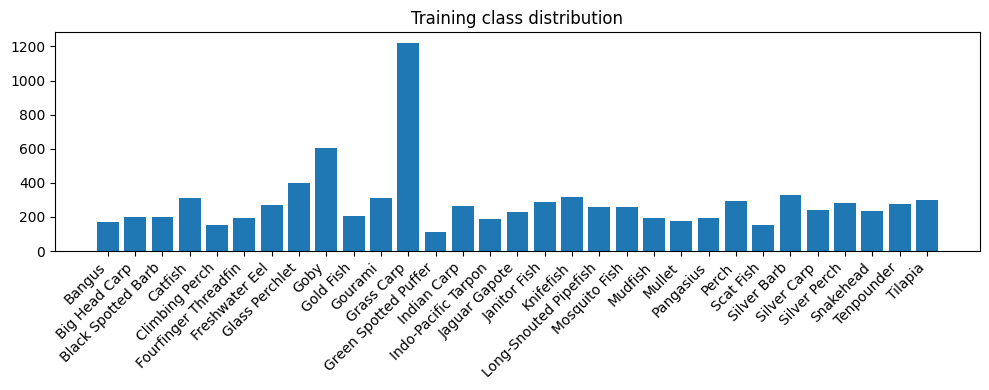

Imbalance ratio (train): 11.11


In [14]:
def count_labels(ds, n_classes):
    counts = np.zeros(n_classes, dtype=np.int64)
    for _, y in ds.unbatch():
        counts[int(y.numpy())] += 1
    return counts

train_counts = count_labels(train_ds, num_classes)
plt.figure(figsize=(10,4))
plt.bar(class_names, train_counts)
plt.xticks(rotation=45, ha="right")
plt.title("Training class distribution")
plt.tight_layout()
plt.show()

imbalance_ratio = train_counts.max() / max(1, train_counts.min())
print(f"Imbalance ratio (train): {imbalance_ratio:.2f}")

In [15]:
total = train_counts.sum()
class_weight = {i: (total / (num_classes * max(1, train_counts[i]))) for i in range(num_classes)}
print("Class weights:")
for i, w in class_weight.items():
    print(f"  {class_names[i]}: {w:.3f}")

Class weights:
  Bangus: 1.664
  Big Head Carp: 1.415
  Black Spotted Barb: 1.422
  Catfish: 0.906
  Climbing Perch: 1.872
  Fourfinger Threadfin: 1.482
  Freshwater Eel: 1.042
  Glass Perchlet: 0.713
  Goby: 0.469
  Gold Fish: 1.381
  Gourami: 0.912
  Grass Carp: 0.233
  Green Spotted Puffer: 2.586
  Indian Carp: 1.086
  Indo-Pacific Tarpon: 1.529
  Jaguar Gapote: 1.242
  Janitor Fish: 0.995
  Knifefish: 0.892
  Long-Snouted Pipefish: 1.111
  Mosquito Fish: 1.111
  Mudfish: 1.489
  Mullet: 1.635
  Pangasius: 1.474
  Perch: 0.971
  Scat Fish: 1.847
  Silver Barb: 0.865
  Silver Carp: 1.195
  Silver Perch: 1.005
  Snakehead: 1.226
  Tenpounder: 1.027
  Tilapia: 0.942


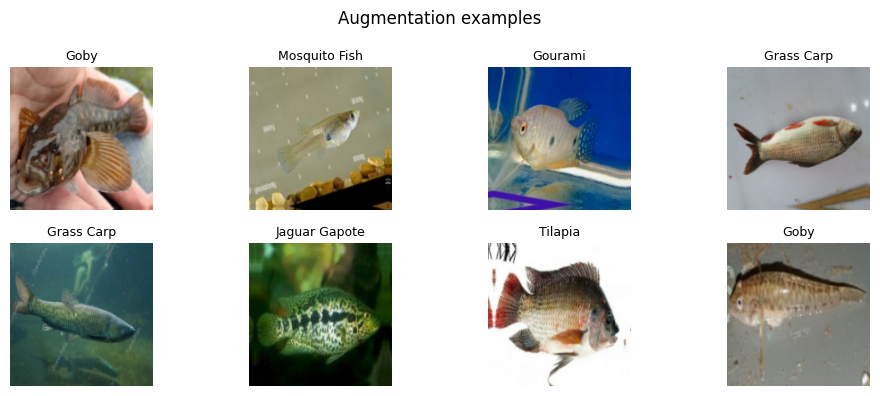

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.10),
], name="augmentation")

# contoh augmentasi 1 batch
for images, labels in train_ds.take(1):
    aug = data_augmentation(images, training=True)
    plt.figure(figsize=(10,4))
    for i in range(8):
        ax = plt.subplot(2,4,i+1)
        plt.imshow(aug[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])], fontsize=9)
        plt.axis("off")
    plt.suptitle("Augmentation examples")
    plt.tight_layout()
    plt.show()

Model: "SmallCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,759 (444.37 KB)

 Trainable params: 113,759 (444.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
276/276 ━━━━━━━━━━━━━━━━━━━━ 1130s 4s/step - accuracy: 0.0390 - loss: 3.4305 - val_accuracy: 0.1036 - val_loss: 3.2752 - learning_rate: 0.0010
Epoch 2/8
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.0807 - loss: 3.2598 - val_accuracy: 0.1280 - val_loss: 3.1386 - learning_rate: 0.0010
Epoch 3/8
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1199 - loss: 3.1534 - val_accuracy: 0.1116 - val_loss: 3.1229 - learning_rate: 0.0010
Epoch 4/8
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1384 - loss: 3.0816 - val_accuracy: 0.1301 - val_loss: 2.9798 - learning_rate: 0.0010
Epoch 5/8
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.1495 - loss: 3.0220 - val_accuracy: 0.1429 - val_loss: 2.9627 - learning_rate: 0.0010
Epoch 6/8
276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.1743 - loss: 2.9246 - val_accuracy: 0.1625 - val_loss: 2.8438 - learning_rate: 0.0010
Epoch 7/8
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1905 - loss: 2.

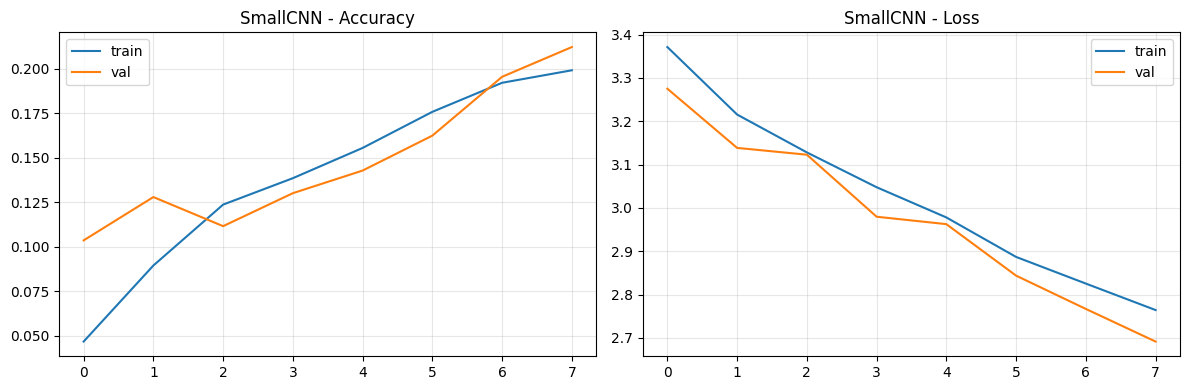

In [17]:
def build_small_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), n_classes=num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = data_augmentation(x)

    # 3 blok conv saja (cukup untuk tugas, jauh lebih ringan)
    for filters in [32, 64, 128]:
        x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs, name="SmallCNN")

cnn_model = build_small_cnn()
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
cnn_model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]

history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,                 # kecilkan epoch
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

# plot history
def plot_history(hist, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history["accuracy"]); plt.plot(hist.history["val_accuracy"])
    plt.title(f"{title} - Accuracy"); plt.legend(["train","val"]); plt.grid(alpha=0.3)

    plt.subplot(1,2,2)
    plt.plot(hist.history["loss"]); plt.plot(hist.history["val_loss"])
    plt.title(f"{title} - Loss"); plt.legend(["train","val"]); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.show()

plot_history(history_cnn, "SmallCNN")


SmallCNN (Scratch) Test Accuracy: 23.06%

Classification Report:
                       precision    recall  f1-score   support

               Bangus      0.000     0.000     0.000        34
        Big Head Carp      0.000     0.000     0.000        43
   Black Spotted Barb      0.154     0.200     0.174        40
              Catfish      0.123     0.355     0.183        62
       Climbing Perch      0.073     0.633     0.130        30
 Fourfinger Threadfin      0.158     0.079     0.105        38
       Freshwater Eel      0.238     0.182     0.206        55
       Glass Perchlet      0.313     0.273     0.292        77
                 Goby      0.554     0.331     0.414       124
            Gold Fish      0.727     0.976     0.833        41
              Gourami      0.412     0.444     0.427        63
           Grass Carp      0.287     0.113     0.163       238
 Green Spotted Puffer      0.250     0.182     0.211        22
          Indian Carp      0.263     0.396     0.31

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


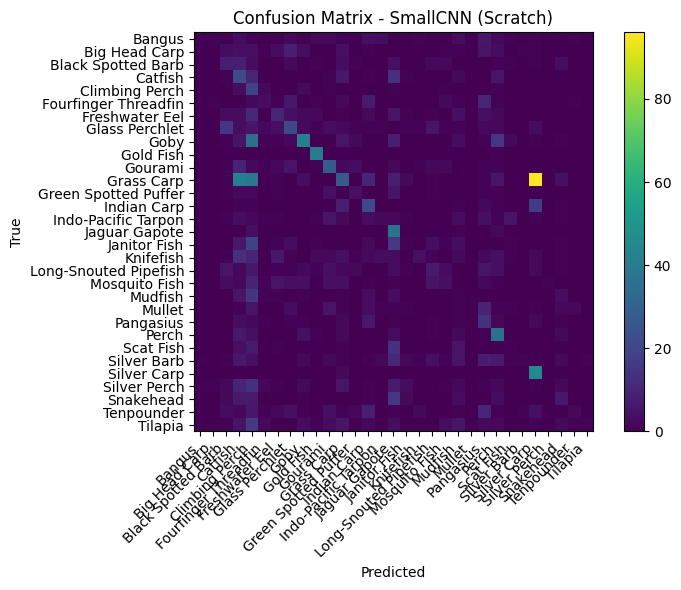

In [18]:
def evaluate_model(model, ds, class_names, title="Model"):
    y_true, y_pred = [], []
    for x, y in ds:
        p = model.predict(x, verbose=0)
        y_true.extend(y.numpy().tolist())
        y_pred.extend(np.argmax(p, axis=1).tolist())

    acc = accuracy_score(y_true, y_pred)
    print(f"\n{title} Test Accuracy: {acc*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(cm)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    return acc, cm

acc_cnn, cm_cnn = evaluate_model(cnn_model, test_ds, class_names, title="SmallCNN (Scratch)")

Model: "MobileNetV2_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_preprocess_input    │ (None, 160, 160, 3)    │             0 │
│ (Lambda)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 31)             │        39,711 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,297,695 (8.77 MB)

 Trainable params: 39,711 (155.12 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.0291 - loss: 3.6906 - val_accuracy: 0.0462 - val_loss: 3.4263 - learning_rate: 0.0010
Epoch 2/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.0348 - loss: 3.5808 - val_accuracy: 0.0523 - val_loss: 3.3941 - learning_rate: 0.0010
Epoch 3/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.0402 - loss: 3.5393 - val_accuracy: 0.0593 - val_loss: 3.3665 - learning_rate: 0.0010
Epoch 4/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.0448 - loss: 3.4976 - val_accuracy: 0.0654 - val_loss: 3.3524 - learning_rate: 0.0010
Epoch 5/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.0456 - loss: 3.4736 - val_accuracy: 0.0680 - val_loss: 3.3453 - learning_rate: 0.0010


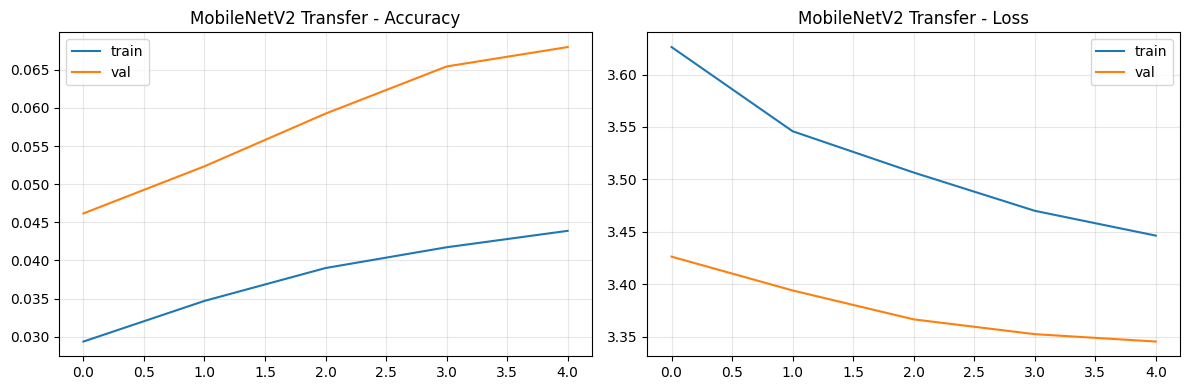


MobileNetV2 (Transfer) Test Accuracy: 6.47%

Classification Report:
                       precision    recall  f1-score   support

               Bangus      0.000     0.000     0.000        34
        Big Head Carp      0.000     0.000     0.000        43
   Black Spotted Barb      0.000     0.000     0.000        40
              Catfish      0.052     0.823     0.097        62
       Climbing Perch      0.000     0.000     0.000        30
 Fourfinger Threadfin      0.000     0.000     0.000        38
       Freshwater Eel      0.000     0.000     0.000        55
       Glass Perchlet      0.000     0.000     0.000        77
                 Goby      0.000     0.000     0.000       124
            Gold Fish      0.000     0.000     0.000        41
              Gourami      0.000     0.000     0.000        63
           Grass Carp      0.079     0.013     0.022       238
 Green Spotted Puffer      0.000     0.000     0.000        22
          Indian Carp      0.286     0.264     0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


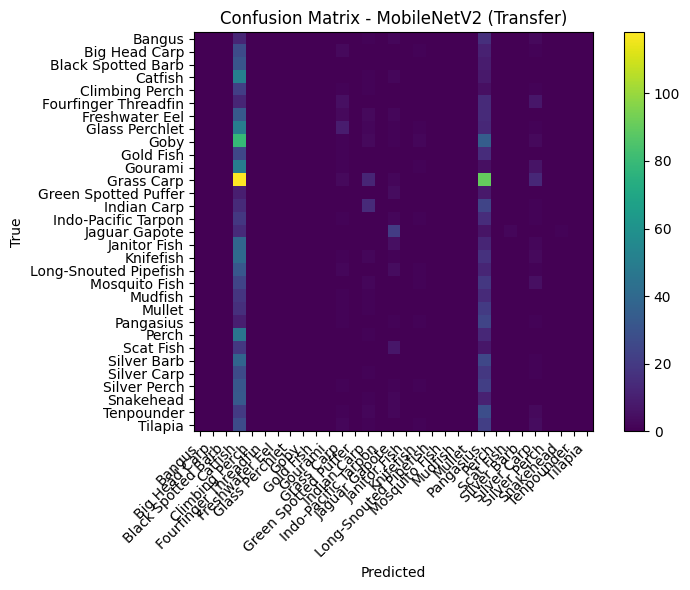

In [23]:
base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # freeze -> cepat

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input, name="mobilenetv2_preprocess_input")(x) # Wrapped in Lambda layer
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
tl_model = tf.keras.Model(inputs, outputs, name="MobileNetV2_TL")

tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
tl_model.summary()

history_tl = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,                 # kecil
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)
plot_history(history_tl, "MobileNetV2 Transfer")

acc_tl, cm_tl = evaluate_model(tl_model, test_ds, class_names, title="MobileNetV2 (Transfer)")

In [24]:
print("\n=== Model Comparison ===")
print(f"SmallCNN (Scratch): {acc_cnn*100:.2f}%")
print(f"MobileNetV2 (TL)  : {acc_tl*100:.2f}%")


=== Model Comparison ===
SmallCNN (Scratch): 23.06%
MobileNetV2 (TL)  : 6.47%


Backbone: mobilenetv2_1.00_160
Last conv-like layer: Conv_1
True: Bangus | Pred: Pangasius (9.0%)


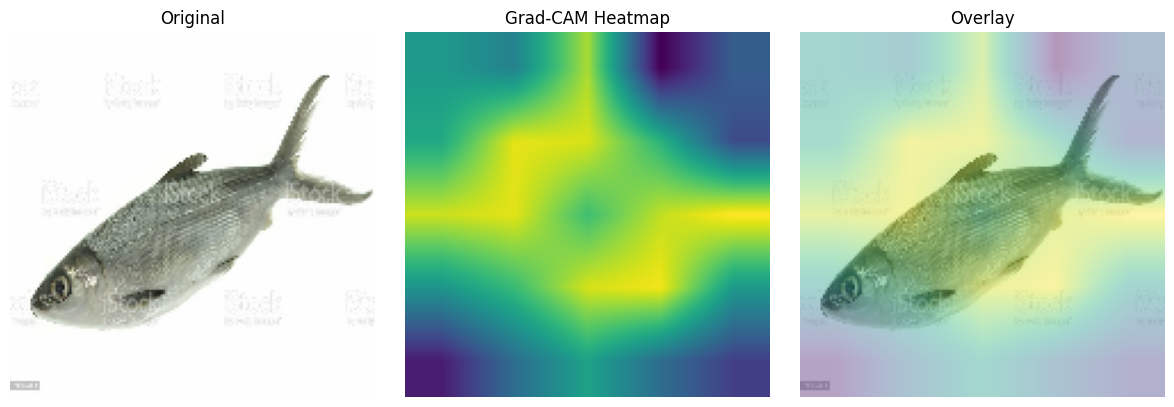

In [32]:
backbone = tl_model.get_layer("mobilenetv2_1.00_160")

# Cari layer conv terakhir (Conv2D/DepthwiseConv2D)
conv_types = (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)
last_conv_name = None
for layer in reversed(backbone.layers):
    if isinstance(layer, conv_types):
        last_conv_name = layer.name
        break
if last_conv_name is None:
    raise ValueError("Tidak menemukan Conv2D/DepthwiseConv2D di backbone.")

print("Backbone:", backbone.name)
print("Last conv-like layer:", last_conv_name)

# Ambil layer preprocessing/head dari tl_model (berdasarkan tipe)
def first_layer_of_type(model, layer_type):
    for l in model.layers:
        if isinstance(l, layer_type):
            return l
    return None

rescale_layer = first_layer_of_type(tl_model, tf.keras.layers.Rescaling)
aug_layer     = tl_model.get_layer("augmentation")  # ada di model Anda
gap_layer     = first_layer_of_type(tl_model, tf.keras.layers.GlobalAveragePooling2D)
drop_layer    = first_layer_of_type(tl_model, tf.keras.layers.Dropout)
dense_layer   = None
# ambil Dense terakhir
for l in reversed(tl_model.layers):
    if isinstance(l, tf.keras.layers.Dense):
        dense_layer = l
        break

# cari layer preprocess_input mobilenetv2 (biasanya Lambda)
prep_layer = None
for l in tl_model.layers:
    if "preprocess" in l.name.lower():
        prep_layer = l
        break
if prep_layer is None:
    raise ValueError("Layer preprocess_input tidak ditemukan. Cek tl_model.summary().")

# Model untuk ambil conv_out dan backbone_out dalam 1 call backbone
backbone_with_conv = tf.keras.Model(
    inputs=backbone.input,
    outputs=[backbone.get_layer(last_conv_name).output, backbone.output]
)

def gradcam_heatmap(img_tensor):
    with tf.GradientTape() as tape:
        # forward sama seperti tl_model (training=False biar stabil)
        x = rescale_layer(img_tensor)
        x = aug_layer(x, training=False)
        x = prep_layer(x)

        conv_out, feat_out = backbone_with_conv(x, training=False)

        # PENTING: agar gradien terhadap conv_out tidak None
        tape.watch(conv_out)

        x = gap_layer(feat_out)
        x = drop_layer(x, training=False)
        preds = dense_layer(x)

        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)
    if grads is None:
        raise ValueError("Gradient masih None. Pastikan tape.watch(conv_out) dieksekusi dan graph terhubung.")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-9)
    return heatmap.numpy(), preds.numpy()

# Ambil 1 gambar dari test
for imgs, labels in test_ds.take(1):
    img = imgs[0:1]
    true_label = int(labels[0].numpy())
    break

heatmap, preds = gradcam_heatmap(img)
pred_class = int(np.argmax(preds[0]))

print("True:", class_names[true_label], "| Pred:", class_names[pred_class], f"({preds[0][pred_class]*100:.1f}%)")

# Overlay
img_np = img[0].numpy().astype("uint8")
heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy().squeeze()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(heatmap_resized); plt.title("Grad-CAM Heatmap"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(img_np); plt.imshow(heatmap_resized, alpha=0.4); plt.title("Overlay"); plt.axis("off")
plt.tight_layout()
plt.show()